<a href="https://colab.research.google.com/github/Prakhyasingh/BIG-DATA/blob/main/MODULE%205%20LAB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [46]:
# Install PySpark
!pip install pyspark

# Import necessary libraries
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler, StandardScaler, PCA
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.linalg import Vectors
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Initialize a Spark session
spark = SparkSession.builder.appName("BostonHousing").getOrCreate()

# Upload the dataset
from google.colab import files
uploaded = files.upload()

# Read the dataset
df = spark.read.csv("BostonHousing.csv", header=True, inferSchema=True)
df.show(5)

+-------+----+-----+----+-----+-----+----+------+---+---+-------+------+-----+----+
|   crim|  zn|indus|chas|  nox|   rm| age|   dis|rad|tax|ptratio|     b|lstat|medv|
+-------+----+-----+----+-----+-----+----+------+---+---+-------+------+-----+----+
|0.00632|18.0| 2.31|   0|0.538|6.575|65.2|  4.09|  1|296|   15.3| 396.9| 4.98|24.0|
|0.02731| 0.0| 7.07|   0|0.469|6.421|78.9|4.9671|  2|242|   17.8| 396.9| 9.14|21.6|
|0.02729| 0.0| 7.07|   0|0.469|7.185|61.1|4.9671|  2|242|   17.8|392.83| 4.03|34.7|
|0.03237| 0.0| 2.18|   0|0.458|6.998|45.8|6.0622|  3|222|   18.7|394.63| 2.94|33.4|
|0.06905| 0.0| 2.18|   0|0.458|7.147|54.2|6.0622|  3|222|   18.7| 396.9| 5.33|36.2|
+-------+----+-----+----+-----+-----+----+------+---+---+-------+------+-----+----+
only showing top 5 rows



##Combine Features into a Single Vector Column


In [47]:
# Combine features to a single vector column using VectorAssembler
feature_cols = [col for col in df.columns if col != 'medv']
assembler = VectorAssembler(inputCols=feature_cols, outputCol='features')
df = assembler.transform(df)

##Standardize Features

In [48]:
# Standardize features for principal component analysis
scaler = StandardScaler(inputCol='features', outputCol='scaled_features', withStd=True, withMean=True)
scaler_model = scaler.fit(df)
df = scaler_model.transform(df)

##Train PCA Model

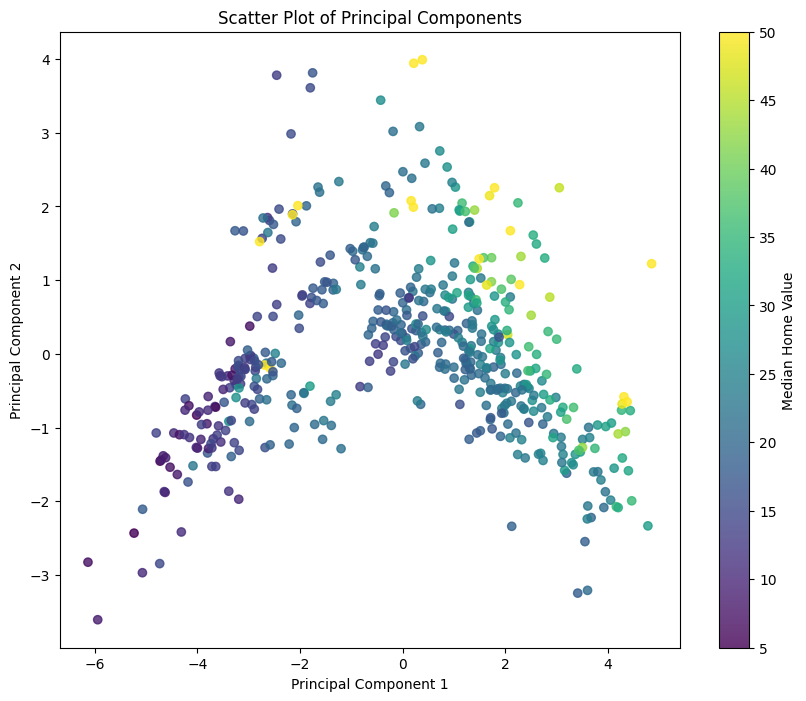

In [49]:
# Train model for two principal component analysis
pca = PCA(k=2, inputCol='scaled_features', outputCol='pca_features')
pca_model = pca.fit(df)
pca_result = pca_model.transform(df).select('pca_features', 'medv')

# Collect distributed data in numpy array and then convert to pandas dataframe
pca_data = pca_result.collect()
pca_array = np.array([[float(i) for i in row['pca_features']] + [row['medv']] for row in pca_data])
pca_df = pd.DataFrame(pca_array, columns=['pca1', 'pca2', 'medv'])

# Plot two principal components
plt.figure(figsize=(10, 8))
plt.scatter(pca_df['pca1'], pca_df['pca2'], c=pca_df['medv'], cmap='viridis', alpha=0.8)
plt.colorbar(label='Median Home Value')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Scatter Plot of Principal Components')
plt.show()

##VECTORIZATION AND MODEL FIT

Coefficients: [-0.977325078745046,1.1406822132685321,0.16324504123061745,0.7116333928728624,-2.133936592267314,2.4703173958890168,0.1467029188600288,-2.982492178640501,2.888780728502063,-2.2934351604834595,-2.0640900942975704,0.7853802659203177,-3.709806672002421]
Intercept: 22.596434879491607
Root Mean Squared Error (RMSE) on test data: 4.67
R-squared: 0.79
Mean Absolute Error (MAE): 3.51
Mean Absolute Percentage Error (MAPE): 18.70%


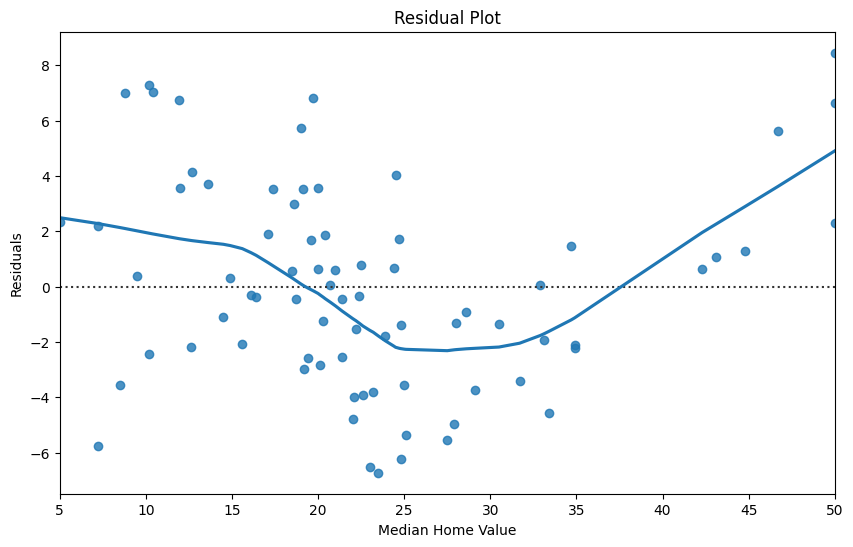

    Feature  Coefficient
0      crim    -0.977325
1        zn     1.140682
2     indus     0.163245
3      chas     0.711633
4       nox    -2.133937
5        rm     2.470317
6       age     0.146703
7       dis    -2.982492
8       rad     2.888781
9       tax    -2.293435
10  ptratio    -2.064090
11        b     0.785380
12    lstat    -3.709807


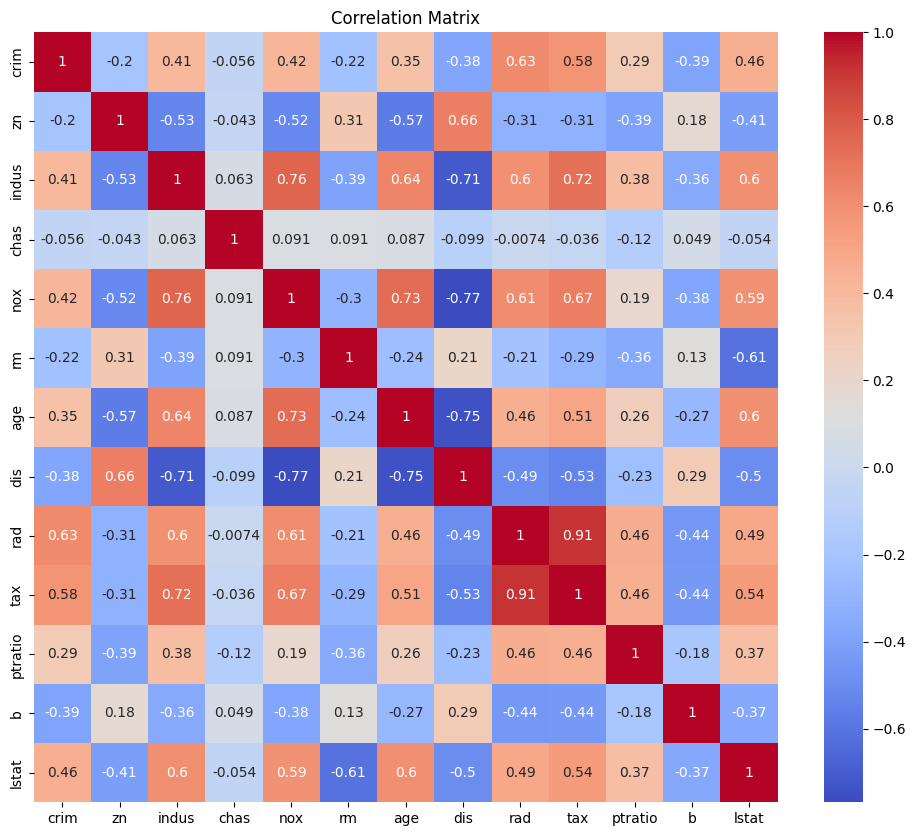

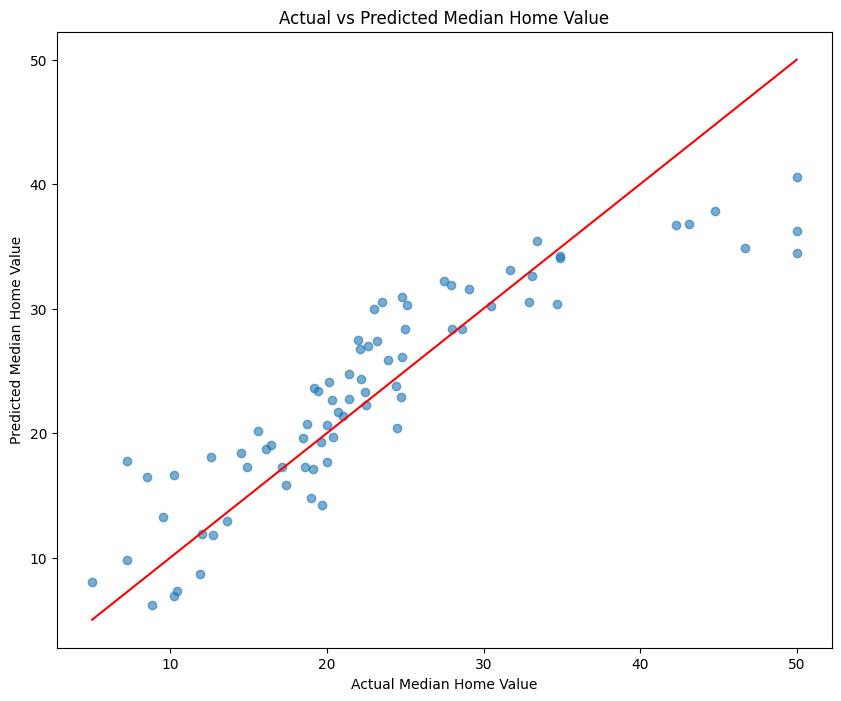

In [50]:
# Vectorize features and target together for model development
vector_assembler = VectorAssembler(inputCols=['scaled_features'], outputCol='features_with_target')
df = vector_assembler.transform(df)

# Split dataset into training and testing dataset
train_df, test_df = df.randomSplit([0.8, 0.2], seed=42)

# Fit model for linear regression
lr = LinearRegression(featuresCol='scaled_features', labelCol='medv')
lr_model = lr.fit(train_df)

# Find out model coefficients and intercept
print(f"Coefficients: {lr_model.coefficients}")
print(f"Intercept: {lr_model.intercept}")

# Evaluate model for test dataset
predictions = lr_model.transform(test_df)
evaluator = RegressionEvaluator(labelCol='medv', predictionCol='prediction', metricName='rmse')
rmse = evaluator.evaluate(predictions)

print(f"Root Mean Squared Error (RMSE) on test data: {rmse:.2f}")

# Additional evaluation metrics
evaluator_r2 = RegressionEvaluator(labelCol='medv', predictionCol='prediction', metricName='r2')
evaluator_mae = RegressionEvaluator(labelCol='medv', predictionCol='prediction', metricName='mae')
r2 = evaluator_r2.evaluate(predictions)
mae = evaluator_mae.evaluate(predictions)

# Compute MAPE
predictions_and_labels = predictions.select('prediction', 'medv').rdd.map(lambda row: (row[0], row[1])).collect()
pred_values, true_values = zip(*predictions_and_labels)
mape = np.mean(np.abs((np.array(true_values) - np.array(pred_values)) / np.array(true_values))) * 100

print(f"R-squared: {r2:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")

# Residual plot
residuals = predictions.select('medv', 'prediction', (predictions['medv'] - predictions['prediction']).alias('residuals'))
residuals_pd = residuals.toPandas()

plt.figure(figsize=(10, 6))
sns.residplot(x=residuals_pd['medv'], y=residuals_pd['residuals'], lowess=True)
plt.xlabel('Median Home Value')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()

# Analyze coefficients
coefficients = pd.DataFrame(list(zip(feature_cols, lr_model.coefficients)), columns=['Feature', 'Coefficient'])
print(coefficients)

# Check for multicollinearity
corr_matrix = df.select(feature_cols).toPandas().corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

# Perform further analysis for better interpretation of model results
plt.figure(figsize=(10, 8))
plt.scatter([row['medv'] for row in predictions.select('medv').collect()],
            [row['prediction'] for row in predictions.select('prediction').collect()], alpha=0.6)
plt.xlabel('Actual Median Home Value')
plt.ylabel('Predicted Median Home Value')
plt.title('Actual vs Predicted Median Home Value')
plt.plot([min(pca_df['medv']), max(pca_df['medv'])], [min(pca_df['medv']), max(pca_df['medv'])], color='red')
plt.show()